# Standalone Material Type Classification

直接训练 Material Type 分类模型（无 progressive pretrain），
评估 ALL test 和 n_elements ≥ 4 两种条件下的 per-class metrics。

训练完成后输出：
- `clf_report_all.json` / `clf_report_ge4.json`
- `metrics.json`
- `confusion_matrix.png`
- Per-class metrics 图（每个 class 一组 1×3 subplots）

In [1]:
from __future__ import annotations

import copy
import json
from datetime import datetime
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
from loguru import logger as fm_logger
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from foundation_model.data.datamodule import CompoundDataModule
from foundation_model.models.flexible_multi_task_model import FlexibleMultiTaskModel
from foundation_model.models.model_config import (
    ClassificationTaskConfig,
    EncoderType,
    MLPEncoderConfig,
    OptimizerConfig,
    TaskType,
)

torch.serialization.add_safe_globals(
    [ClassificationTaskConfig, OptimizerConfig, MLPEncoderConfig, TaskType, EncoderType]
)

%matplotlib inline
print("Imports done.")

Imports done.


## 1. Configuration

In [2]:
# === Data paths (相对于 notebooks/ 目录) ===
DATA_PATH = Path("../data/qc_ac_te_mp_dos_reformat_20250615_enforce_quaternary_test.pd.parquet")
DESCRIPTOR_PATH = Path("../data/qc_ac_te_mp_dos_composition_desc_trans_20250615.pd.parquet")
PREPROCESSING_PATH = Path("../data/preprocessing_objects_20250615.pkl.z")

# === Output ===
OUTPUT_DIR = Path(f"../artifacts/standalone_clf_{datetime.now().strftime('%y%m%d_%H%M')}")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# === Training hyperparameters ===
N_RUNS = 5               # Number of independent repeats
MAX_EPOCHS = 200
BATCH_SIZE = 128
NUM_WORKERS = 0
EARLY_STOPPING_PATIENCE = 50
LOG_EVERY_N_STEPS = 50
RANDOM_SEED_BASE = 1729
DATAMODULE_RANDOM_SEED = 42

# === Model architecture ===
LATENT_DIM = 128
HEAD_HIDDEN_DIM = 64
HEAD_LR = 0.005
ENCODER_LR = 5e-2

# === Hardware ===
ACCELERATOR = "auto"
DEVICES = "auto"

# Suppress verbose model logging
fm_logger.disable("foundation_model")

print(f"Output dir: {OUTPUT_DIR}")
print(f"N_RUNS={N_RUNS}, MAX_EPOCHS={MAX_EPOCHS}, BATCH_SIZE={BATCH_SIZE}")

Output dir: ../artifacts/standalone_clf_260213_0038
N_RUNS=5, MAX_EPOCHS=200, BATCH_SIZE=128


## 2. Load Data & Preprocessing Objects

In [3]:
# Load preprocessing objects
preprocessing_objects = joblib.load(PREPROCESSING_PATH)

# Load main data
all_data = pd.read_parquet(DATA_PATH)
dropped_idx = preprocessing_objects.get("dropped_idx", [])
all_data = all_data.loc[~all_data.index.isin(dropped_idx)]

# Load descriptors
desc_trans = pd.read_parquet(DESCRIPTOR_PATH)
x_dim = desc_trans.shape[1]

# Label encoder
le = preprocessing_objects.get("material_type_label_encoder")
if le is not None:
    num_classes = len(le.classes_)
    class_names = list(le.classes_)
else:
    labels = all_data["Material type (label)"].dropna().astype(int)
    num_classes = int(labels.max()) + 1
    class_names = [str(i) for i in range(num_classes)]

# Pre-compute n_elements for ge4 filtering
n_elements_series = all_data["elements"].apply(len)

print(f"Data shape: {all_data.shape}")
print(f"Descriptor shape: {desc_trans.shape} → x_dim = {x_dim}")
print(f"Classes ({num_classes}): {class_names}")
print(f"Samples with n_elements >= 4: {(n_elements_series >= 4).sum()}")

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PowerTransformer from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to un

Data shape: (48998, 49)
Descriptor shape: (48998, 290) → x_dim = 290
Classes (5): ['DAC', 'DQC', 'IAC', 'IQC', 'others']
Samples with n_elements >= 4: 18547


## 3. Model & DataModule Builders

In [4]:
def build_clf_task_config():
    """Build a ClassificationTaskConfig for material_type."""
    return ClassificationTaskConfig(
        name="material_type",
        data_column="Material type (label)",
        dims=[LATENT_DIM, HEAD_HIDDEN_DIM, 32],
        num_classes=num_classes,
        norm=True,
        residual=False,
        optimizer=OptimizerConfig(lr=HEAD_LR, weight_decay=1e-5),
    )


def build_encoder_config():
    """Build the shared MLP encoder config."""
    return MLPEncoderConfig(
        hidden_dims=[x_dim, 256, LATENT_DIM],
        norm=True,
        residual=False,
    )


def build_datamodule():
    """Build a CompoundDataModule for classification."""
    data_col = "Material type (label)"
    columns = [data_col]
    if "split" in all_data.columns:
        columns.append("split")
    attributes = all_data[columns].dropna(subset=[data_col]).copy()

    return CompoundDataModule(
        formula_desc_source=desc_trans,
        attributes_source=attributes,
        task_configs=[build_clf_task_config()],
        random_seed=DATAMODULE_RANDOM_SEED,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
    )


def collect_clf_predictions(batch_preds):
    """Collect classification predictions from trainer.predict() output."""
    labels, probas = [], []
    for batch in batch_preds:
        if "material_type_label" in batch:
            labels.append(batch["material_type_label"])
        if "material_type_proba" in batch:
            probas.append(batch["material_type_proba"])
    pred_labels = np.concatenate(labels) if labels else np.array([])
    pred_probas = np.concatenate(probas) if probas else None
    return pred_labels, pred_probas


def collect_clf_true(dataset):
    """Collect ground truth labels from a dataset."""
    y_list = []
    for i in range(len(dataset)):
        sample = dataset[i]
        y = sample[1]["material_type"]
        y_list.append(y.numpy())
    return np.concatenate(y_list)


print("Builder functions defined.")

Builder functions defined.


## 4. Training Loop

Seed set to 1729
Seed set to 1730
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Run 1/5


/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/core/optimizer.py:317: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.

  | Name                | Type              | Params | Mode 
------------------------------------------------------------------
0 | task_log_sigmas     | ParameterDict     | 0      | train
1 | encoder             | FoundationEncoder | 108 K  | train
2 | task_heads          | ModuleDict        | 10.7 K | train
3 | disabled_task_heads | ModuleDict        | 0      | train
4 | val_r2_metrics      | ModuleDict        | 0      | train
5 | test_r2_metrics     | ModuleDict        | 0      | train
------------------------------------------------------------------
118 K     Trainable params
0         Non-trainable params
118 K     Total params
0.475     Total estimated model params size (MB)
26        Modules in train mode
0

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 181: 100%|██████████| 268/268 [00:02<00:00, 128.60it/s, v_num=0, train_final_loss_step=0.000352, val_final_loss=0.00822, train_final_loss_epoch=0.00409]
  Loaded best checkpoint: /Users/liuchang/projects/foundation_model/artifacts/standalone_clf_260213_0038/run01/finetune/material_type/checkpoints/material_type-epoch=131-val_final_loss=0.0074.ckpt


/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting DataLoader 0: 100%|██████████| 58/58 [00:00<00:00, 431.05it/s]

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:484: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Predicting DataLoader 0: 100%|██████████| 268/268 [00:00<00:00, 459.08it/s]
  test_acc=0.9936, train_acc=0.9884
  [ALL test] (7354 samples)
              precision    recall  f1-score   support

         DAC     0.3333    0.5000    0.4000         2
         DQC     0.0000    0.0000    0.0000         9
         IAC     0.8000    0.7500    0.7742        32
         IQC     0.8101    0.7711    0.7901        83
      others     0.9967    0.9986    0.9977      7228

    accuracy                         0.9936      7354
   macro avg     0.5880    0.6039    0.5924      7354
weighted avg     0.9923    0.9936    0.9930      7354

  [n_elements >= 4] (2817 samples, acc=0.9894)
              precision    recall  f1-score   support

         DAC     0.0000    0.0000    0.0000         1
         DQC     0.0000    0.0000    0.0000         7
         IAC     1.0000    0.5455    0.7059        11
         IQC     0.8679    0.7302    0.7931        63
      others     0.9917    1.0000    0.9958      273

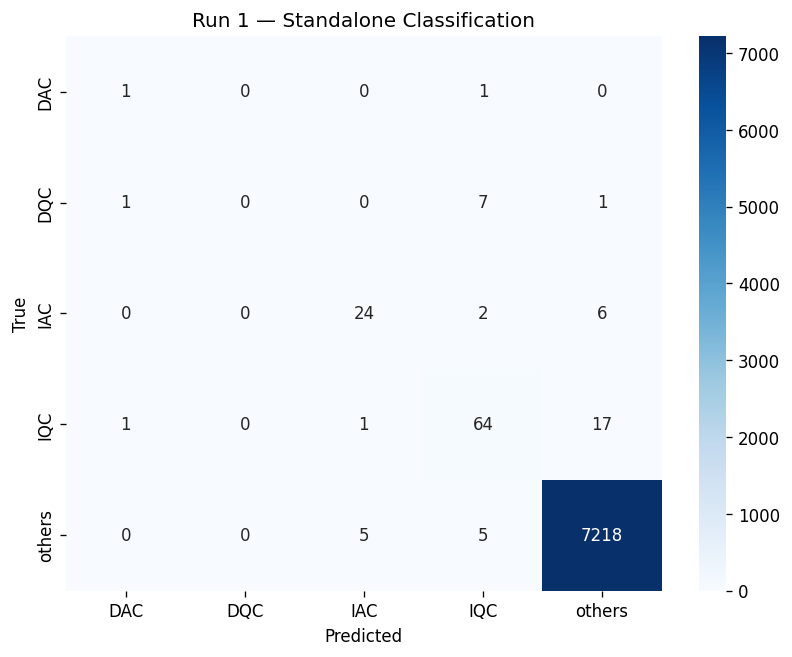

Seed set to 1731


  Saved to ../artifacts/standalone_clf_260213_0038/run01/finetune/material_type

Run 2/5


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/core/optimizer.py:317: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.

  | Name                | Type              | Params | Mode 
------------------------------------------------------------------
0 | task_log_sigmas     | ParameterDict     | 0      | train
1 | encoder             | FoundationEncoder | 108 K  | train
2 | task_heads          | ModuleDict        | 10.7 K | train
3 | disabled_task_heads | ModuleDict        | 0      | train
4 | val_r2_metrics      | ModuleDict        | 0      | train
5 | test_r2_metrics     | ModuleDict        | 0      | train
------------------------------------------------------------------
118 K     Trainable params
0         Non-trainab

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 199: 100%|██████████| 268/268 [00:02<00:00, 126.30it/s, v_num=0, train_final_loss_step=0.00171, val_final_loss=0.00906, train_final_loss_epoch=0.00415] 

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 268/268 [00:02<00:00, 126.11it/s, v_num=0, train_final_loss_step=0.00171, val_final_loss=0.00906, train_final_loss_epoch=0.00415]
  Loaded best checkpoint: /Users/liuchang/projects/foundation_model/artifacts/standalone_clf_260213_0038/run02/finetune/material_type/checkpoints/material_type-epoch=169-val_final_loss=0.0071.ckpt


/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting DataLoader 0: 100%|██████████| 58/58 [00:00<00:00, 414.16it/s]

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:484: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Predicting DataLoader 0: 100%|██████████| 268/268 [00:00<00:00, 449.86it/s]
  test_acc=0.9928, train_acc=0.9885
  [ALL test] (7354 samples)
              precision    recall  f1-score   support

         DAC     0.5000    0.5000    0.5000         2
         DQC     0.0000    0.0000    0.0000         9
         IAC     0.8889    0.7500    0.8136        32
         IQC     0.7639    0.6627    0.7097        83
      others     0.9956    0.9990    0.9973      7228

    accuracy                         0.9928      7354
   macro avg     0.6297    0.5823    0.6041      7354
weighted avg     0.9912    0.9928    0.9919      7354

  [n_elements >= 4] (2817 samples, acc=0.9858)
              precision    recall  f1-score   support

         DAC     0.0000    0.0000    0.0000         1
         DQC     0.0000    0.0000    0.0000         7
         IAC     1.0000    0.5455    0.7059        11
         IQC     0.8000    0.5714    0.6667        63
      others     0.9888    1.0000    0.9944      273

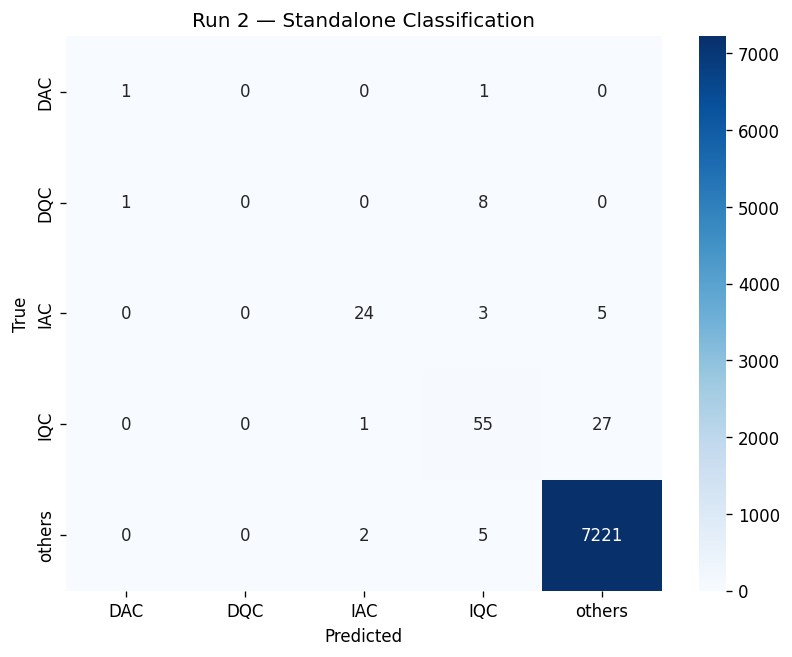

  Saved to ../artifacts/standalone_clf_260213_0038/run02/finetune/material_type


Seed set to 1732



Run 3/5


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/core/optimizer.py:317: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.

  | Name                | Type              | Params | Mode 
------------------------------------------------------------------
0 | task_log_sigmas     | ParameterDict     | 0      | train
1 | encoder             | FoundationEncoder | 108 K  | train
2 | task_heads          | ModuleDict        | 10.7 K | train
3 | disabled_task_heads | ModuleDict        | 0      | train
4 | val_r2_metrics      | ModuleDict        | 0      | train
5 | test_r2_metrics     | ModuleDict        | 0      | train
------------------------------------------------------------------
118 K     Trainable params
0         Non-trainab

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 199: 100%|██████████| 268/268 [00:02<00:00, 125.40it/s, v_num=0, train_final_loss_step=9.41e-6, val_final_loss=0.00742, train_final_loss_epoch=0.00407] 

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 268/268 [00:02<00:00, 125.23it/s, v_num=0, train_final_loss_step=9.41e-6, val_final_loss=0.00742, train_final_loss_epoch=0.00407]
  Loaded best checkpoint: /Users/liuchang/projects/foundation_model/artifacts/standalone_clf_260213_0038/run03/finetune/material_type/checkpoints/material_type-epoch=158-val_final_loss=0.0067.ckpt


/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting DataLoader 0: 100%|██████████| 58/58 [00:00<00:00, 483.56it/s]

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:484: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Predicting DataLoader 0: 100%|██████████| 268/268 [00:00<00:00, 447.20it/s]
  test_acc=0.9946, train_acc=0.9885
  [ALL test] (7354 samples)
              precision    recall  f1-score   support

         DAC     0.5000    0.5000    0.5000         2
         DQC     0.0000    0.0000    0.0000         9
         IAC     0.8800    0.6875    0.7719        32
         IQC     0.7955    0.8434    0.8187        83
      others     0.9975    0.9990    0.9983      7228

    accuracy                         0.9946      7354
   macro avg     0.6346    0.6060    0.6178      7354
weighted avg     0.9934    0.9946    0.9939      7354

  [n_elements >= 4] (2817 samples, acc=0.9908)
              precision    recall  f1-score   support

         DAC     0.0000    0.0000    0.0000         1
         DQC     0.0000    0.0000    0.0000         7
         IAC     1.0000    0.4545    0.6250        11
         IQC     0.8361    0.8095    0.8226        63
      others     0.9942    1.0000    0.9971      273

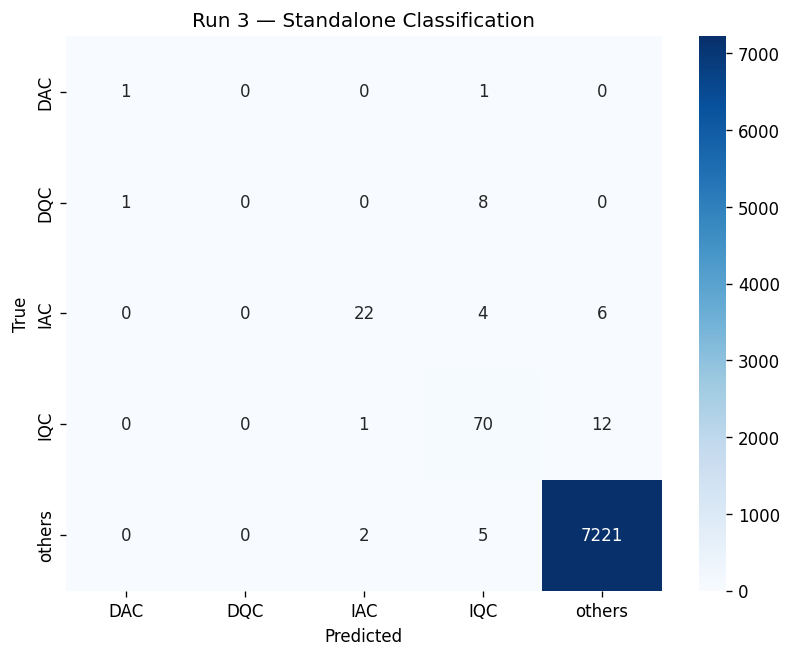

Seed set to 1733
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  Saved to ../artifacts/standalone_clf_260213_0038/run03/finetune/material_type

Run 4/5


/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/core/optimizer.py:317: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.

  | Name                | Type              | Params | Mode 
------------------------------------------------------------------
0 | task_log_sigmas     | ParameterDict     | 0      | train
1 | encoder             | FoundationEncoder | 108 K  | train
2 | task_heads          | ModuleDict        | 10.7 K | train
3 | disabled_task_heads | ModuleDict        | 0      | train
4 | val_r2_metrics      | ModuleDict        | 0      | train
5 | test_r2_metrics     | ModuleDict        | 0      | train
------------------------------------------------------------------
118 K     Trainable params
0         Non-trainable params
118 K     Total params
0.475     Total estimated model params size (MB)
26        Modules in train mode
0

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 199: 100%|██████████| 268/268 [00:02<00:00, 125.52it/s, v_num=0, train_final_loss_step=0.0205, val_final_loss=0.00679, train_final_loss_epoch=0.00354]  

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 268/268 [00:02<00:00, 125.34it/s, v_num=0, train_final_loss_step=0.0205, val_final_loss=0.00679, train_final_loss_epoch=0.00354]
  Loaded best checkpoint: /Users/liuchang/projects/foundation_model/artifacts/standalone_clf_260213_0038/run04/finetune/material_type/checkpoints/material_type-epoch=178-val_final_loss=0.0061.ckpt


/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting DataLoader 0: 100%|██████████| 58/58 [00:00<00:00, 461.94it/s]

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:484: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Predicting DataLoader 0: 100%|██████████| 268/268 [00:00<00:00, 421.55it/s]
  test_acc=0.9946, train_acc=0.9881
  [ALL test] (7354 samples)
              precision    recall  f1-score   support

         DAC     0.0000    0.0000    0.0000         2
         DQC     0.5000    0.1111    0.1818         9
         IAC     0.7667    0.7188    0.7419        32
         IQC     0.7895    0.9036    0.8427        83
      others     0.9985    0.9982    0.9983      7228

    accuracy                         0.9946      7354
   macro avg     0.6109    0.5463    0.5530      7354
weighted avg     0.9942    0.9946    0.9942      7354

  [n_elements >= 4] (2817 samples, acc=0.9922)
              precision    recall  f1-score   support

         DAC     0.0000    0.0000    0.0000         1
         DQC     0.0000    0.0000    0.0000         7
         IAC     1.0000    0.4545    0.6250        11
         IQC     0.8261    0.9048    0.8636        63
      others     0.9964    0.9993    0.9978      273

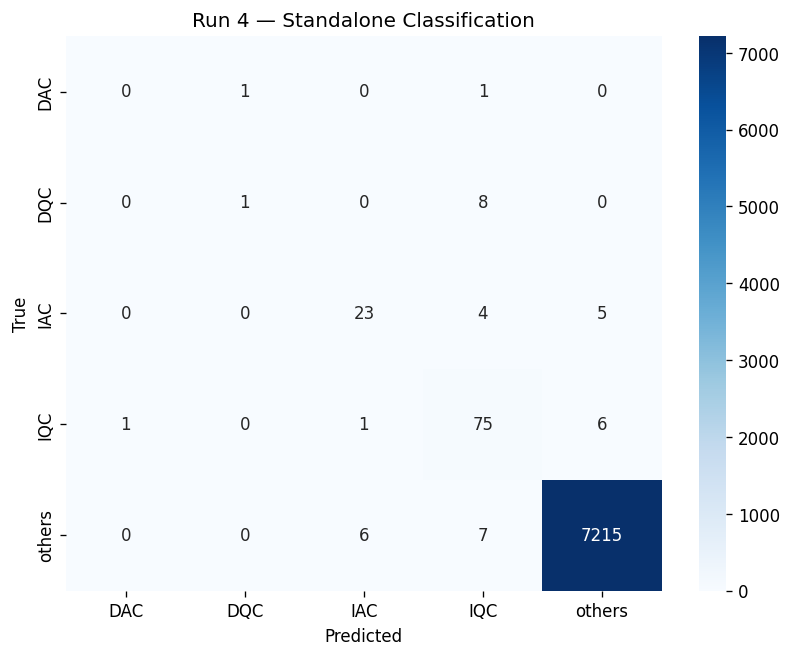

Seed set to 1734
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  Saved to ../artifacts/standalone_clf_260213_0038/run04/finetune/material_type

Run 5/5


/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/core/optimizer.py:317: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.

  | Name                | Type              | Params | Mode 
------------------------------------------------------------------
0 | task_log_sigmas     | ParameterDict     | 0      | train
1 | encoder             | FoundationEncoder | 108 K  | train
2 | task_heads          | ModuleDict        | 10.7 K | train
3 | disabled_task_heads | ModuleDict        | 0      | train
4 | val_r2_metrics      | ModuleDict        | 0      | train
5 | test_r2_metrics     | ModuleDict        | 0      | train
------------------------------------------------------------------
118 K     Trainable params
0         Non-trainable params
118 K     Total params
0.475     Total estimated model params size (MB)
26        Modules in train mode
0

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 177: 100%|██████████| 268/268 [00:02<00:00, 123.40it/s, v_num=0, train_final_loss_step=0.00545, val_final_loss=0.00711, train_final_loss_epoch=0.00393] 
  Loaded best checkpoint: /Users/liuchang/projects/foundation_model/artifacts/standalone_clf_260213_0038/run05/finetune/material_type/checkpoints/material_type-epoch=127-val_final_loss=0.0068.ckpt


/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting DataLoader 0: 100%|██████████| 58/58 [00:00<00:00, 405.79it/s]

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:484: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Predicting DataLoader 0: 100%|██████████| 268/268 [00:00<00:00, 387.79it/s]
  test_acc=0.9950, train_acc=0.9882
  [ALL test] (7354 samples)
              precision    recall  f1-score   support

         DAC     0.2000    0.5000    0.2857         2
         DQC     0.0000    0.0000    0.0000         9
         IAC     0.8276    0.7500    0.7869        32
         IQC     0.8182    0.8675    0.8421        83
      others     0.9983    0.9989    0.9986      7228

    accuracy                         0.9950      7354
   macro avg     0.5688    0.6233    0.5827      7354
weighted avg     0.9941    0.9950    0.9945      7354

  [n_elements >= 4] (2817 samples, acc=0.9918)
              precision    recall  f1-score   support

         DAC     0.0000    0.0000    0.0000         1
         DQC     0.0000    0.0000    0.0000         7
         IAC     1.0000    0.5455    0.7059        11
         IQC     0.8548    0.8413    0.8480        63
      others     0.9960    1.0000    0.9980      273

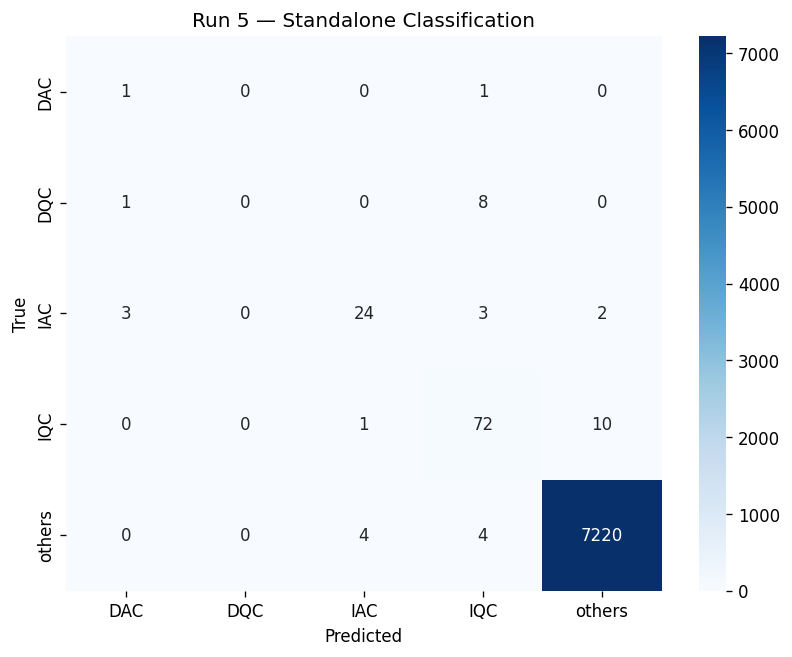

  Saved to ../artifacts/standalone_clf_260213_0038/run05/finetune/material_type

All runs complete. Summary saved to ../artifacts/standalone_clf_260213_0038/summary.json


In [ ]:
torch.set_float32_matmul_precision("medium")
seed_everything(RANDOM_SEED_BASE)

all_results = []  # List of per-run result dicts

for run_idx in range(1, N_RUNS + 1):
    run_label = f"run{run_idx:02d}"
    run_dir = OUTPUT_DIR / run_label / "finetune" / "material_type"
    run_dir.mkdir(parents=True, exist_ok=True)

    print(f"\n{'=' * 60}")
    print(f"Run {run_idx}/{N_RUNS}")
    print(f"{'=' * 60}")

    seed_everything(RANDOM_SEED_BASE + run_idx)

    # Build fresh model (no pretrained encoder)
    model = FlexibleMultiTaskModel(
        task_configs=[build_clf_task_config()],
        encoder_config=build_encoder_config(),
        enable_learnable_loss_balancer=False,
        shared_block_optimizer=OptimizerConfig(lr=ENCODER_LR),
    )

    dm = build_datamodule()

    # Callbacks
    ckpt_cb = ModelCheckpoint(
        dirpath=run_dir / "checkpoints",
        filename="material_type-{epoch:02d}-{val_final_loss:.4f}",
        monitor="val_final_loss",
        mode="min",
        save_top_k=1,
    )
    early_stop = EarlyStopping(
        monitor="val_final_loss",
        mode="min",
        patience=EARLY_STOPPING_PATIENCE,
    )
    loggers = [
        CSVLogger(run_dir / "logs", name="csv"),
        TensorBoardLogger(run_dir / "logs", name="tensorboard"),
    ]

    trainer = Trainer(
        max_epochs=MAX_EPOCHS,
        accelerator=ACCELERATOR,
        devices=DEVICES,
        callbacks=[ckpt_cb, early_stop],
        logger=loggers,
        log_every_n_steps=LOG_EVERY_N_STEPS,
    )

    # Train
    trainer.fit(model, datamodule=dm)

    # Load best checkpoint
    best_path = ckpt_cb.best_model_path
    if best_path:
        state = torch.load(best_path, map_location="cpu", weights_only=True)
        model.load_state_dict(state.get("state_dict", state))
        print(f"  Loaded best checkpoint: {best_path}")

    # === Evaluate ===
    dm.setup(stage="fit")
    dm.setup(stage="test")

    test_preds = trainer.predict(model, dataloaders=dm.test_dataloader())
    train_preds = trainer.predict(model, dataloaders=dm.train_dataloader())

    test_labels, test_probas = collect_clf_predictions(test_preds)
    test_true = collect_clf_true(dm.test_dataset)
    train_labels, _ = collect_clf_predictions(train_preds)
    train_true = collect_clf_true(dm.train_dataset)

    test_mask = test_true.flatten() != -100
    train_mask = train_true.flatten() != -100

    # n_elements >= 4 mask
    test_n_elem = n_elements_series.loc[dm.test_idx].values
    ge4_mask = test_n_elem >= 4
    test_ge4_mask = test_mask & ge4_mask

    test_acc = float(accuracy_score(test_true.flatten()[test_mask], test_labels.flatten()[test_mask]))
    train_acc = float(accuracy_score(train_true.flatten()[train_mask], train_labels.flatten()[train_mask]))

    # Classification reports
    clf_report_all = classification_report(
        test_true.flatten()[test_mask],
        test_labels.flatten()[test_mask],
        target_names=class_names,
        digits=4,
        output_dict=True,
        zero_division=0,
    )
    n_ge4 = int(test_ge4_mask.sum())
    if n_ge4 > 0:
        clf_report_ge4 = classification_report(
            test_true.flatten()[test_ge4_mask],
            test_labels.flatten()[test_ge4_mask],
            target_names=class_names,
            digits=4,
            output_dict=True,
            zero_division=0,
        )
    else:
        clf_report_ge4 = {}

    # Train split reports
    train_n_elem = n_elements_series.loc[dm.train_idx].values
    train_ge4_mask = train_mask & (train_n_elem >= 4)

    # Print results
    print(f"  test_acc={test_acc:.4f}, train_acc={train_acc:.4f}")
    print(f"  [ALL test] ({test_mask.sum()} samples)")
    print(
        classification_report(
            test_true.flatten()[test_mask],
            test_labels.flatten()[test_mask],
            target_names=class_names,
            digits=4,
            zero_division=0,
        )
    )
    if n_ge4 > 0:
        test_acc_ge4 = accuracy_score(
            test_true.flatten()[test_ge4_mask],
            test_labels.flatten()[test_ge4_mask],
        )
        print(f"  [n_elements >= 4] ({n_ge4} samples, acc={test_acc_ge4:.4f})")
        print(
            classification_report(
                test_true.flatten()[test_ge4_mask],
                test_labels.flatten()[test_ge4_mask],
                target_names=class_names,
                digits=4,
                zero_division=0,
            )
        )

    # Confusion matrix (ALL test)
    cm = confusion_matrix(
        test_true.flatten()[test_mask], test_labels.flatten()[test_mask],
        labels=list(range(num_classes)),
    )
    np.save(run_dir / "confusion_matrix_all.npy", cm)

    fig, ax = plt.subplots(figsize=(8, 6), dpi=120)
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=class_names, yticklabels=class_names, ax=ax,
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(f"Run {run_idx} — Standalone Classification (ALL test)")
    fig.savefig(run_dir / "confusion_matrix.png", bbox_inches="tight")
    plt.show()
    plt.close(fig)

    # Confusion matrix (n_elements >= 4)
    if n_ge4 > 0:
        cm_ge4 = confusion_matrix(
            test_true.flatten()[test_ge4_mask], test_labels.flatten()[test_ge4_mask],
            labels=list(range(num_classes)),
        )
        np.save(run_dir / "confusion_matrix_ge4.npy", cm_ge4)

        fig, ax = plt.subplots(figsize=(8, 6), dpi=120)
        sns.heatmap(
            cm_ge4, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names, ax=ax,
        )
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        ax.set_title(f"Run {run_idx} — Standalone Classification (n_elements >= 4)")
        fig.savefig(run_dir / "confusion_matrix_ge4.png", bbox_inches="tight")
        plt.show()
        plt.close(fig)

    # Save results to disk
    run_results = {
        "run": run_label,
        "test_accuracy": test_acc,
        "train_accuracy": train_acc,
        "test_accuracy_ge4": float(accuracy_score(
            test_true.flatten()[test_ge4_mask], test_labels.flatten()[test_ge4_mask]
        )) if n_ge4 > 0 else None,
        "n_test_all": int(test_mask.sum()),
        "n_test_ge4": n_ge4,
        "n_train_all": int(train_mask.sum()),
        "n_train_ge4": int(train_ge4_mask.sum()),
        "checkpoint": best_path or None,
    }
    with open(run_dir / "clf_report_all.json", "w") as f:
        json.dump(clf_report_all, f, indent=2, default=str)
    with open(run_dir / "clf_report_ge4.json", "w") as f:
        json.dump(clf_report_ge4, f, indent=2, default=str)
    with open(run_dir / "metrics.json", "w") as f:
        json.dump(run_results, f, indent=2, default=str)

    all_results.append(run_results)
    print(f"  Saved to {run_dir}")

# Save summary
with open(OUTPUT_DIR / "summary.json", "w") as f:
    json.dump(all_results, f, indent=2, default=str)

print(f"\nAll runs complete. Summary saved to {OUTPUT_DIR / 'summary.json'}")

## 5. Results Summary

In [21]:
print("=== Accuracy Summary ===")
accs = [r["test_accuracy"] for r in all_results if r["test_accuracy"] is not None]
accs_ge4 = [r["test_accuracy_ge4"] for r in all_results if r["test_accuracy_ge4"] is not None]

print(f"  ALL test:       mean={np.mean(accs):.4f} ± {np.std(accs):.4f}  (n={len(accs)} runs)")
if accs_ge4:
    print(f"  n_elements>=4:  mean={np.mean(accs_ge4):.4f} ± {np.std(accs_ge4):.4f}  (n={len(accs_ge4)} runs)")

print("\n=== Per-Run Detail ===")
for r in all_results:
    line = f"  {r['run']}: test_acc={r['test_accuracy']:.4f}"
    if r.get("test_accuracy_ge4") is not None:
        line += f", test_acc_ge4={r['test_accuracy_ge4']:.4f}"
    line += f", train_acc={r['train_accuracy']:.4f}"
    print(line)

=== Accuracy Summary ===
  ALL test:       mean=0.9941 ± 0.0008  (n=5 runs)
  n_elements>=4:  mean=0.9900 ± 0.0023  (n=5 runs)

=== Per-Run Detail ===
  run01: test_acc=0.9936, test_acc_ge4=0.9894, train_acc=0.9884
  run02: test_acc=0.9928, test_acc_ge4=0.9858, train_acc=0.9885
  run03: test_acc=0.9946, test_acc_ge4=0.9908, train_acc=0.9885
  run04: test_acc=0.9946, test_acc_ge4=0.9922, train_acc=0.9881
  run05: test_acc=0.9950, test_acc_ge4=0.9918, train_acc=0.9882


## 6. Per-class Metrics (ALL test)

每个 class 一组 1×3 subplots（Precision / Recall / F1-score），
用 bar chart 展示各 run 的结果及 mean±std。

In [22]:
def load_clf_reports(output_dir: Path, report_name: str = "clf_report_all.json"):
    """Load clf reports from all runs. Returns {run_label: {1: report}} to match progressive format."""
    reports = {}
    for p in sorted(output_dir.glob(f"run*/finetune/material_type/{report_name}")):
        run_label = p.relative_to(output_dir).parts[0]
        with open(p) as f:
            # Wrap single report as stage_idx=1 to reuse same plotting function as progressive notebook
            reports[run_label] = {1: json.load(f)}
    return reports


def plot_per_class_metrics(
    reports_by_run,
    class_names,
    n_stages,
    title_suffix="",
    save_dir=None,
):
    """
    为每个 class 绘制独立的 1×3 subplots（precision, recall, f1-score）。
    每组图: mean ± std 随 pretrain stage 数量的变化。
    reports_by_run: {run_label: {stage_idx: clf_report_dict}}
    返回和之前一样的 arr (shape [n_runs, n_stages, n_classes, n_metrics])。

    NOTE: 此函数与 progressive_clf_analysis.ipynb 中的完全一致，
    以确保两个 notebook 产出的图可以直接对比。
    """
    metrics_of_interest = ["precision", "recall", "f1-score"]
    n_classes = len(class_names)
    n_metrics = len(metrics_of_interest)
    n_runs = len(reports_by_run)

    # shape [n_runs, n_stages, n_classes, n_metrics]
    arr = np.full((n_runs, n_stages, n_classes, n_metrics), np.nan)

    for r_idx, (run_label, stages_dict) in enumerate(sorted(reports_by_run.items())):
        for s_idx_1based, report in stages_dict.items():
            s_idx = s_idx_1based - 1  # 0-based
            if not report:
                continue
            for c_idx, cname in enumerate(class_names):
                if cname in report:
                    for m_idx, metric in enumerate(metrics_of_interest):
                        arr[r_idx, s_idx, c_idx, m_idx] = report[cname].get(metric, np.nan)

    mean_vals = np.nanmean(arr, axis=0)
    std_vals = np.nanstd(arr, axis=0)
    stages_x = np.arange(1, n_stages + 1)
    colors = plt.cm.tab10.colors

    for c_idx, cname in enumerate(class_names):
        fig, axes = plt.subplots(1, n_metrics, figsize=(4 * n_metrics, 3.5), sharey=True)

        for m_idx, metric in enumerate(metrics_of_interest):
            ax = axes[m_idx]
            mu = mean_vals[:, c_idx, m_idx]
            sd = std_vals[:, c_idx, m_idx]

            ax.plot(stages_x, mu, "o-", color=colors[c_idx], linewidth=1.5, markersize=5)
            ax.fill_between(stages_x, mu - sd, mu + sd, alpha=0.2, color=colors[c_idx])

            ax.set_ylim(-0.05, 1.05)
            ax.set_xticks(stages_x)
            ax.set_title(metric.capitalize(), fontsize=12, fontweight="bold")
            ax.set_xlabel("# pretrain source tasks")
            ax.grid(True, alpha=0.3)

        axes[0].set_ylabel("Score", fontsize=11)
        fig.suptitle(
            f"{cname} — Metrics vs Pretrain Stages{title_suffix}",
            fontsize=13, fontweight="bold",
        )
        fig.tight_layout()

        if save_dir:
            safe_suffix = title_suffix.replace(" ", "_").replace("≥", "ge").replace("(", "").replace(")", "")
            save_path = save_dir / f"per_class_{cname}{safe_suffix}.png"
            fig.savefig(save_path, dpi=150, bbox_inches="tight")
            print(f"  Saved: {save_path}")

        plt.show()

    return arr


print("plot_per_class_metrics() defined.")

plot_per_class_metrics() defined.


Found 5 run(s) with clf_report_all
  Saved: ../artifacts/standalone_clf_260213_0038/per_class_DAC_ALL_test.png


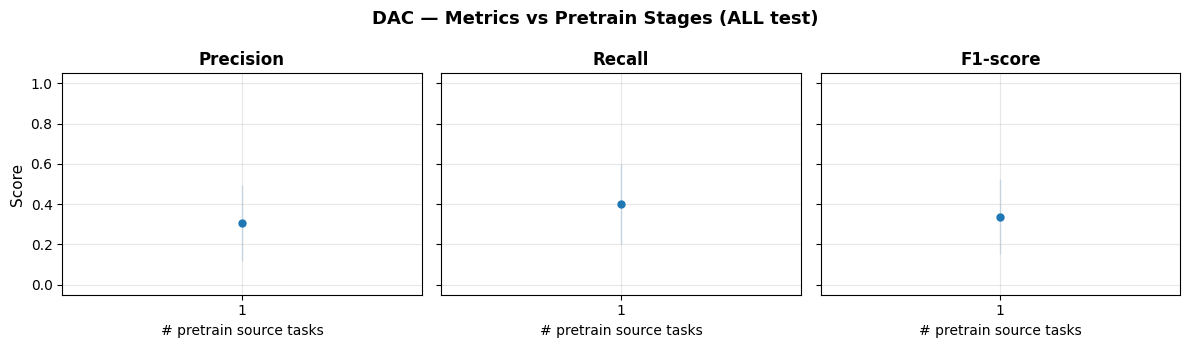

  Saved: ../artifacts/standalone_clf_260213_0038/per_class_DQC_ALL_test.png


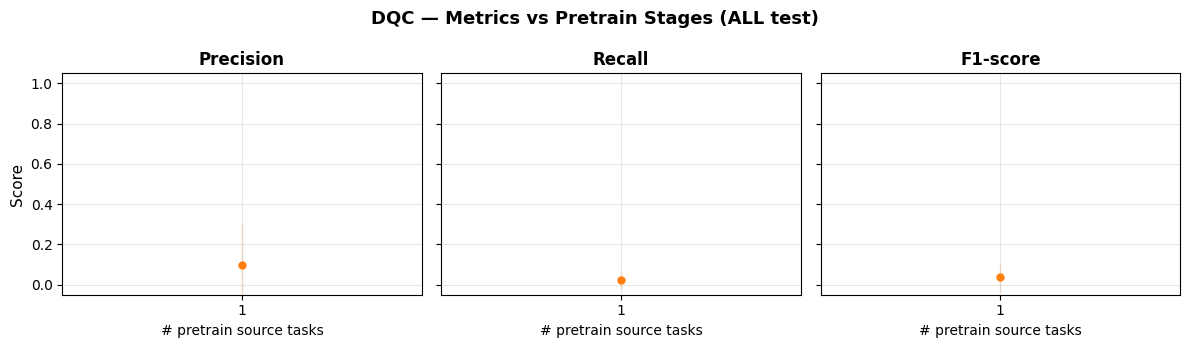

  Saved: ../artifacts/standalone_clf_260213_0038/per_class_IAC_ALL_test.png


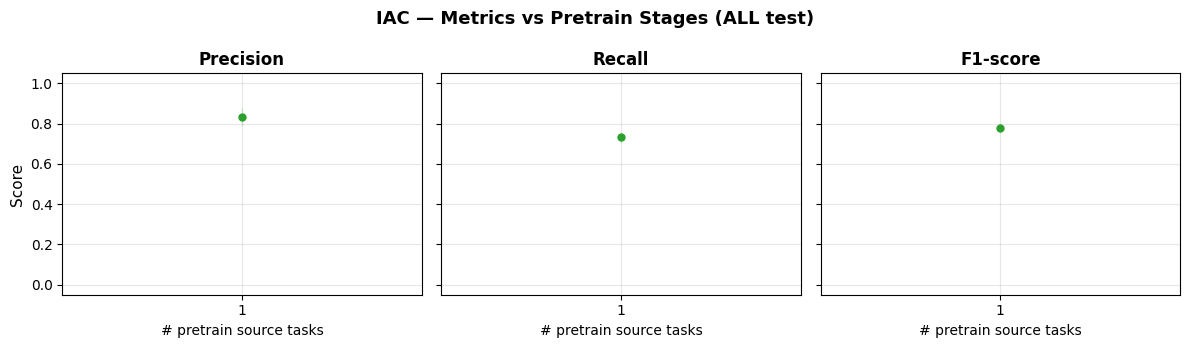

  Saved: ../artifacts/standalone_clf_260213_0038/per_class_IQC_ALL_test.png


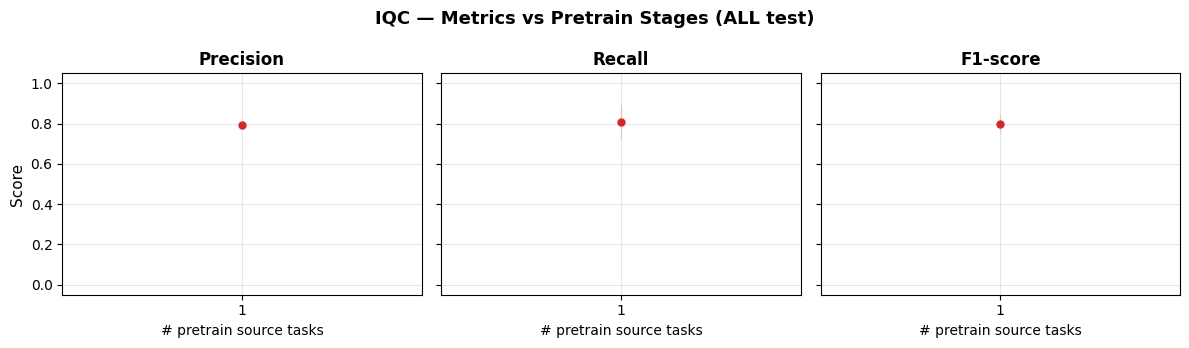

  Saved: ../artifacts/standalone_clf_260213_0038/per_class_others_ALL_test.png


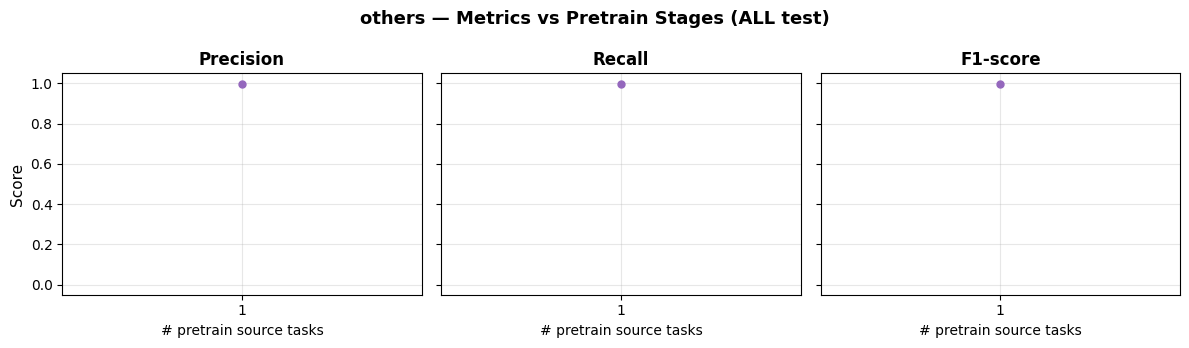

In [23]:
# Load and plot ALL test reports
reports_all = load_clf_reports(OUTPUT_DIR, "clf_report_all.json")
print(f"Found {len(reports_all)} run(s) with clf_report_all")

arr_all = plot_per_class_metrics(
    reports_all, class_names, n_stages=1,
    title_suffix=" (ALL test)",
    save_dir=OUTPUT_DIR,
)

## 7. Per-class Metrics (n_elements ≥ 4)

Found 5 run(s) with clf_report_ge4
  Saved: ../artifacts/standalone_clf_260213_0038/per_class_DAC_n_elements_>=_4.png


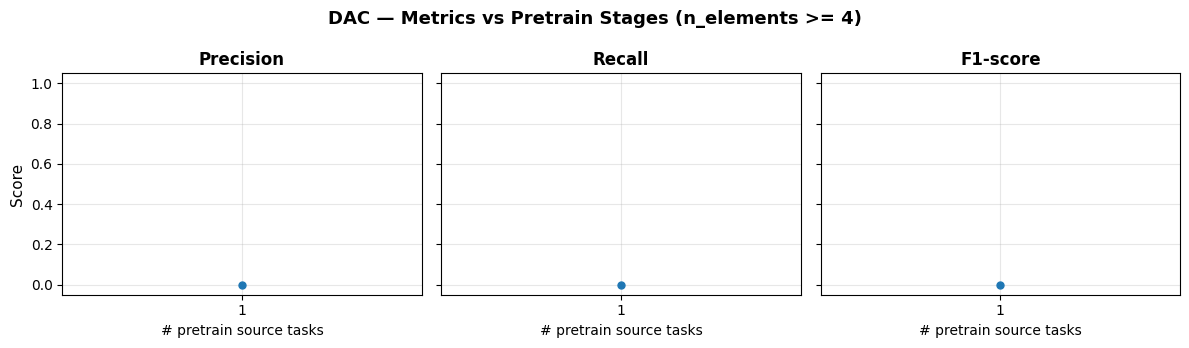

  Saved: ../artifacts/standalone_clf_260213_0038/per_class_DQC_n_elements_>=_4.png


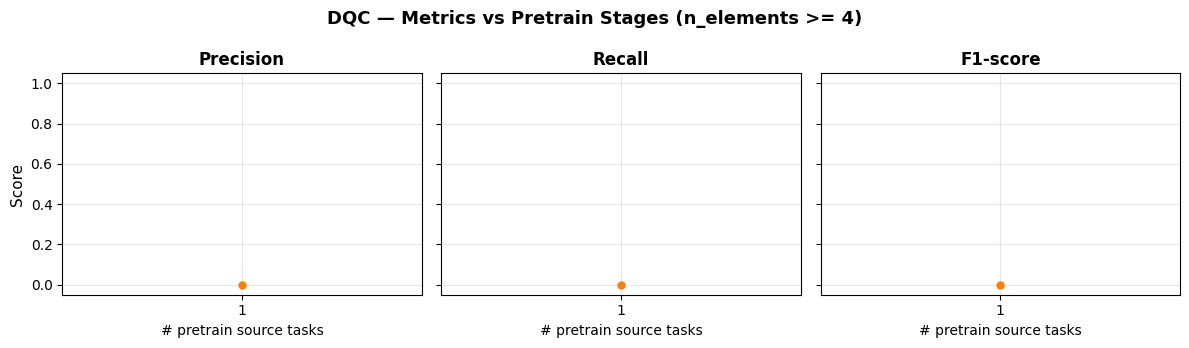

  Saved: ../artifacts/standalone_clf_260213_0038/per_class_IAC_n_elements_>=_4.png


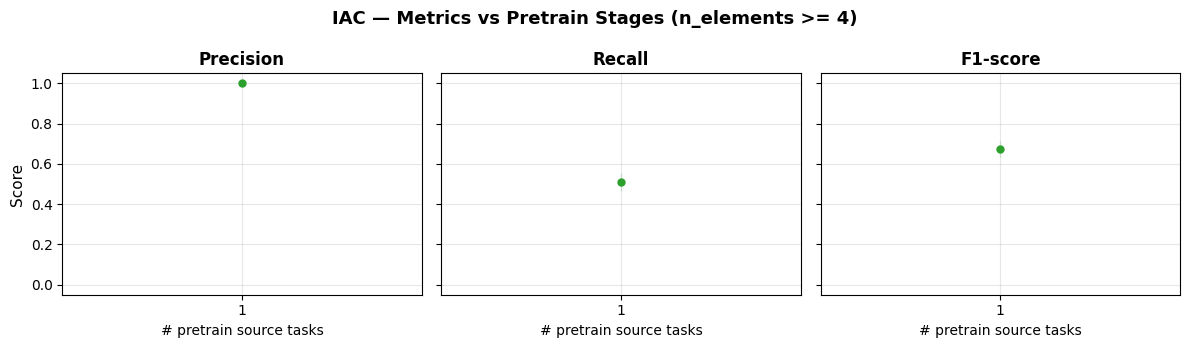

  Saved: ../artifacts/standalone_clf_260213_0038/per_class_IQC_n_elements_>=_4.png


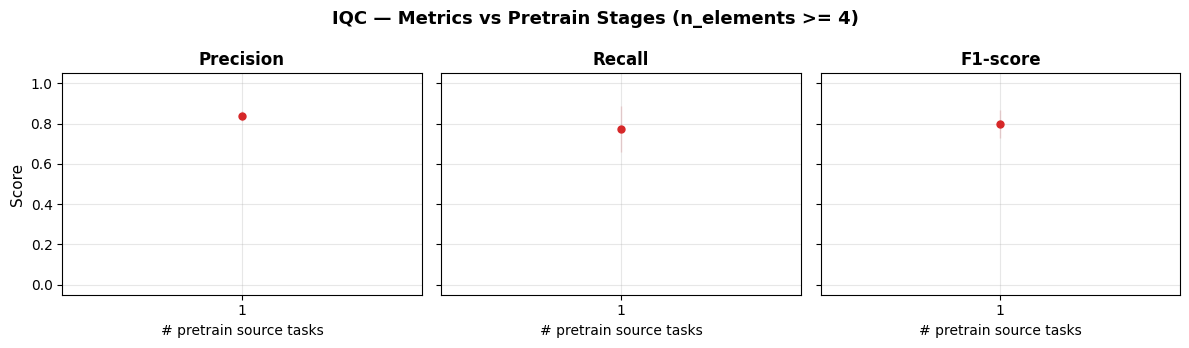

  Saved: ../artifacts/standalone_clf_260213_0038/per_class_others_n_elements_>=_4.png


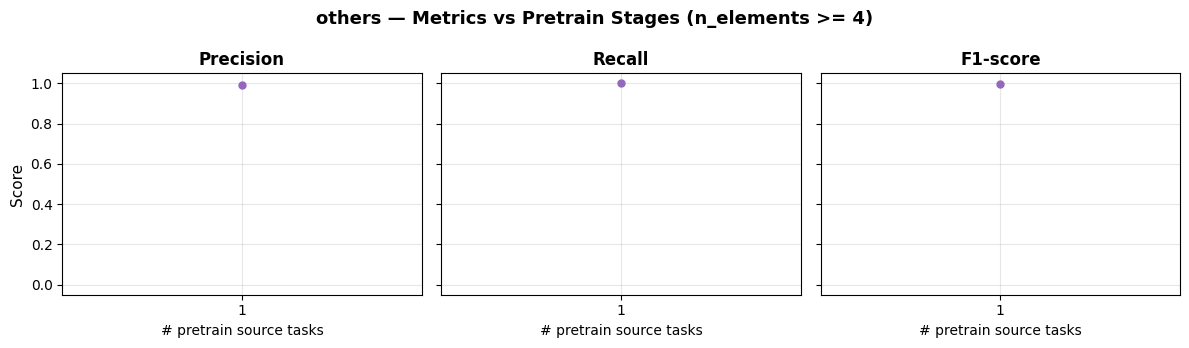

In [24]:
# Load and plot ge4 test reports
reports_ge4 = load_clf_reports(OUTPUT_DIR, "clf_report_ge4.json")
print(f"Found {len(reports_ge4)} run(s) with clf_report_ge4")

arr_ge4 = plot_per_class_metrics(
    reports_ge4, class_names, n_stages=1,
    title_suffix=" (n_elements >= 4)",
    save_dir=OUTPUT_DIR,
)

## 8. Numerical Summary

In [25]:
import pandas as pd

metrics_of_interest = ["precision", "recall", "f1-score"]
n_stages = 1  # standalone has 1 stage

for arr, label in [
    (arr_all, "ALL_test"),
    (arr_ge4, "n_elements_ge_4"),
]:
    print(f"\n=== Per-class Metrics Summary ({label}) ===")
    csv_rows = []
    for c_idx, cname in enumerate(class_names):
        print(f"\n  {cname}:")
        for m_idx, metric in enumerate(metrics_of_interest):
            vals = arr[:, :, c_idx, m_idx]  # [n_runs, n_stages]
            mean_v = np.nanmean(vals, axis=0)
            std_v = np.nanstd(vals, axis=0)
            line = "    " + metric.ljust(12)
            for s in range(n_stages):
                line += f"  S{s+1}: {mean_v[s]:.3f}±{std_v[s]:.3f}"
                csv_rows.append({"class": cname, "metric": metric, "stage": s + 1,
                                 "mean": round(mean_v[s], 4), "std": round(std_v[s], 4)})
            print(line)

    df_metrics = pd.DataFrame(csv_rows)
    csv_path = OUTPUT_DIR / f"per_class_metrics_summary_{label}.csv"
    df_metrics.to_csv(csv_path, index=False)
    print(f"\nSaved to {csv_path}")


=== Per-class Metrics Summary (ALL_test) ===

  DAC:
    precision     S1: 0.307±0.190
    recall        S1: 0.400±0.200
    f1-score      S1: 0.337±0.186

  DQC:
    precision     S1: 0.100±0.200
    recall        S1: 0.022±0.044
    f1-score      S1: 0.036±0.073

  IAC:
    precision     S1: 0.833±0.047
    recall        S1: 0.731±0.025
    f1-score      S1: 0.778±0.023

  IQC:
    precision     S1: 0.795±0.019
    recall        S1: 0.810±0.085
    f1-score      S1: 0.801±0.049

  others:
    precision     S1: 0.997±0.001
    recall        S1: 0.999±0.000
    f1-score      S1: 0.998±0.000

Saved to ../artifacts/standalone_clf_260213_0038/per_class_metrics_summary_ALL_test.csv

=== Per-class Metrics Summary (n_elements_ge_4) ===

  DAC:
    precision     S1: 0.000±0.000
    recall        S1: 0.000±0.000
    f1-score      S1: 0.000±0.000

  DQC:
    precision     S1: 0.000±0.000
    recall        S1: 0.000±0.000
    f1-score      S1: 0.000±0.000

  IAC:
    precision     S1: 1.000±0.0

## 9. Aggregated Confusion Matrix

汇总所有 runs 的 confusion matrix，绘制 mean ± std heatmap。

In [28]:
# === 补充生成 confusion_matrix .npy 文件（如旧 run 未保存） ===
missing_runs = []
for run_path in sorted(OUTPUT_DIR.glob("run*/finetune/material_type")):
    if not (run_path / "confusion_matrix_all.npy").exists():
        missing_runs.append(run_path)

if missing_runs:
    print(f"Found {len(missing_runs)} run(s) missing .npy files, regenerating...")

    # Build a single datamodule (same for all runs since DATAMODULE_RANDOM_SEED is fixed)
    _dm = build_datamodule()
    _dm.setup("fit")
    _dm.setup("test")

    _test_true = collect_clf_true(_dm.test_dataset)
    _test_mask = _test_true.flatten() != -100
    _test_n_elem = n_elements_series.loc[_dm.test_idx].values
    _test_ge4_mask = _test_mask & (_test_n_elem >= 4)

    for run_path in missing_runs:
        ckpt_dir = run_path / "checkpoints"
        ckpts = sorted(ckpt_dir.glob("*.ckpt"))
        if not ckpts:
            print(f"  SKIP {run_path.parts[-4]} — no checkpoint")
            continue

        # Load model from checkpoint
        _model = FlexibleMultiTaskModel(
            task_configs=[build_clf_task_config()],
            encoder_config=build_encoder_config(),
            enable_learnable_loss_balancer=False,
            shared_block_optimizer=OptimizerConfig(lr=ENCODER_LR),
        )
        _state = torch.load(ckpts[0], map_location="cpu", weights_only=True)
        _model.load_state_dict(_state.get("state_dict", _state))
        _model.eval()

        _trainer = Trainer(accelerator=ACCELERATOR, devices=DEVICES, logger=False)
        _preds = _trainer.predict(_model, dataloaders=_dm.test_dataloader())
        _pred_labels, _ = collect_clf_predictions(_preds)

        # ALL test
        _cm_all = confusion_matrix(
            _test_true.flatten()[_test_mask],
            _pred_labels.flatten()[_test_mask],
            labels=list(range(num_classes)),
        )
        np.save(run_path / "confusion_matrix_all.npy", _cm_all)

        # n_elements >= 4
        if _test_ge4_mask.sum() > 0:
            _cm_ge4 = confusion_matrix(
                _test_true.flatten()[_test_ge4_mask],
                _pred_labels.flatten()[_test_ge4_mask],
                labels=list(range(num_classes)),
            )
            np.save(run_path / "confusion_matrix_ge4.npy", _cm_ge4)

        run_name = run_path.parts[-4]
        print(f"  Generated .npy for {run_name}")

    # Cleanup temp vars
    del _dm, _model, _trainer, _preds, _pred_labels, _state, _test_true, _test_mask
    print("Done.")
else:
    print("All runs already have confusion_matrix .npy files.")

All runs already have confusion_matrix .npy files.


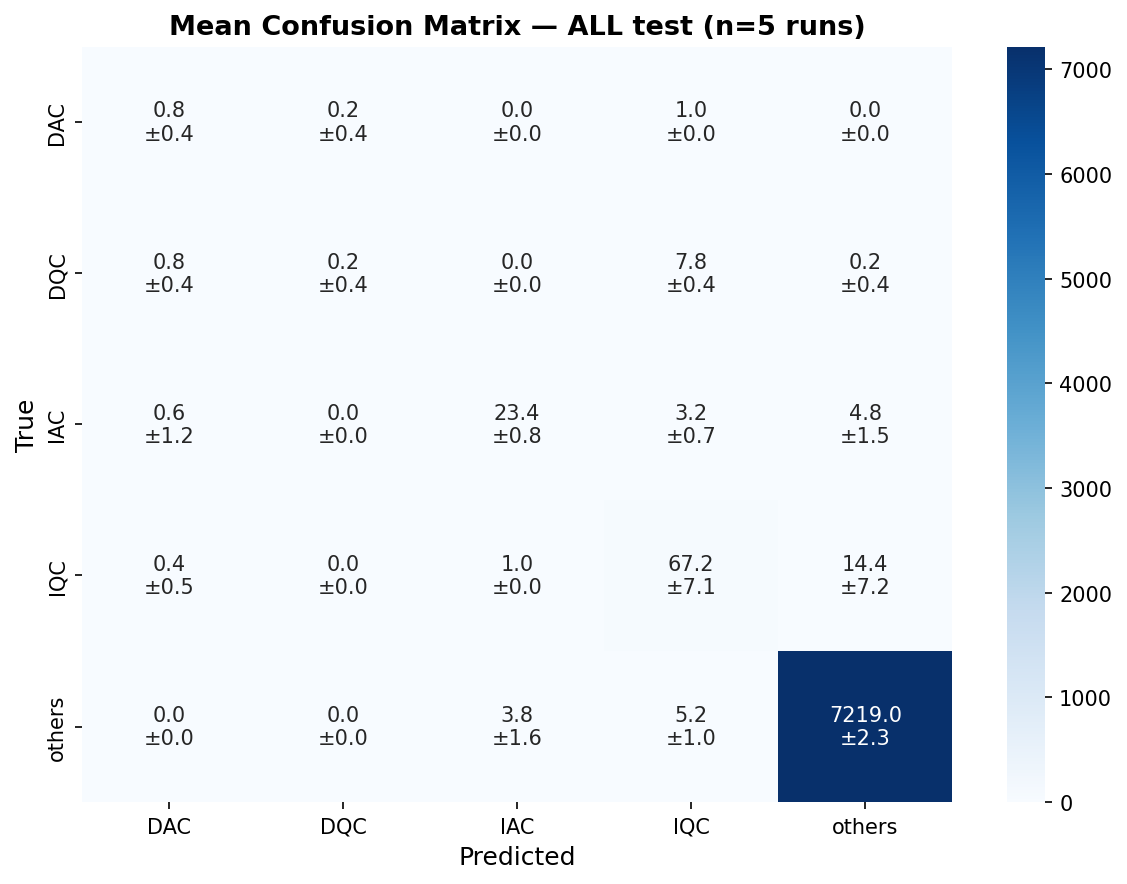

Saved: ../artifacts/standalone_clf_260213_0038/confusion_matrix_mean_ALL_test.png


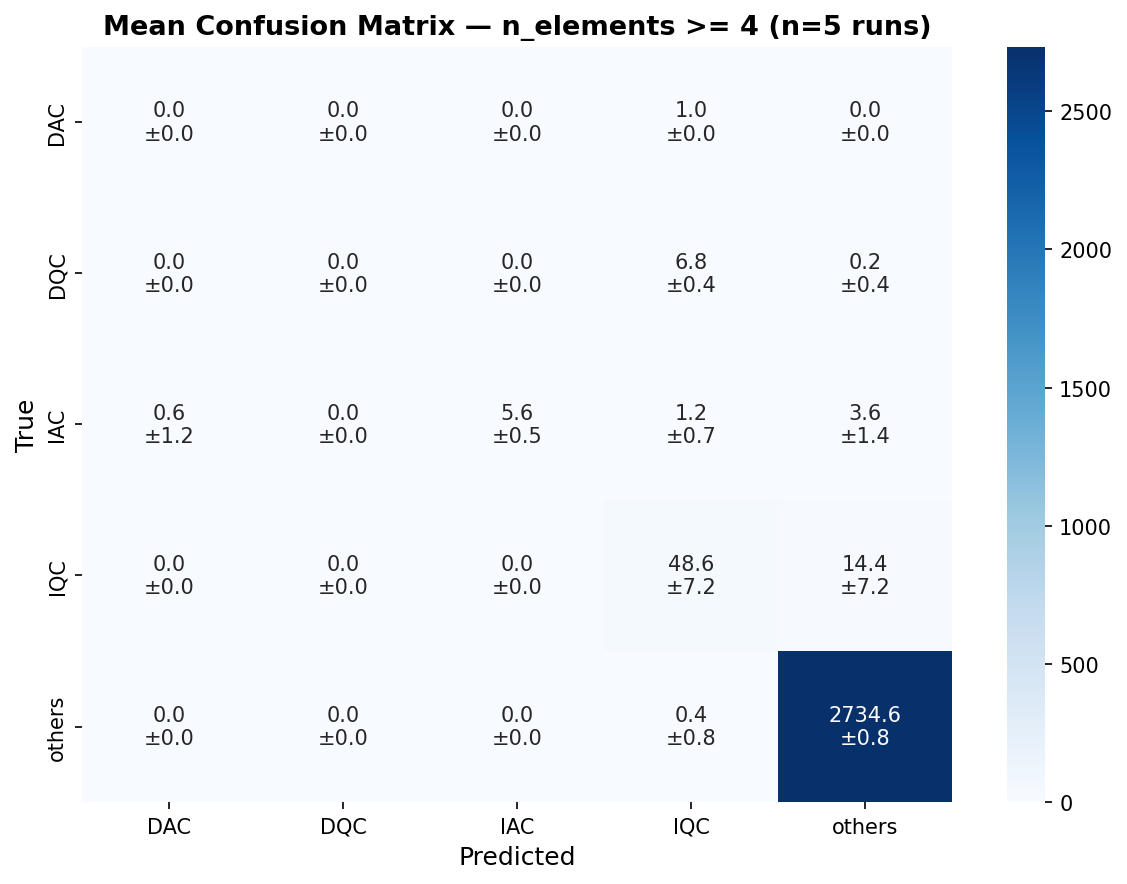

Saved: ../artifacts/standalone_clf_260213_0038/confusion_matrix_mean_n_elements_ge_4.png


In [29]:
def load_confusion_matrices(output_dir: Path, filename: str = "confusion_matrix_all.npy"):
    """Load confusion matrices from all runs."""
    cms = []
    for p in sorted(output_dir.glob(f"run*/finetune/material_type/{filename}")):
        cms.append(np.load(p))
    return np.array(cms) if cms else None


for cm_file, label in [
    ("confusion_matrix_all.npy", "ALL test"),
    ("confusion_matrix_ge4.npy", "n_elements >= 4"),
]:
    cms = load_confusion_matrices(OUTPUT_DIR, cm_file)
    if cms is None or len(cms) == 0:
        print(f"No confusion matrices found for {label}")
        continue

    mean_cm = cms.mean(axis=0)
    std_cm = cms.std(axis=0)

    # Build annotation strings: "mean\n±std"
    annot_arr = np.array([
        [f"{mean_cm[i, j]:.1f}\n±{std_cm[i, j]:.1f}"
         for j in range(mean_cm.shape[1])]
        for i in range(mean_cm.shape[0])
    ])

    fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
    sns.heatmap(
        mean_cm, annot=annot_arr, fmt="", cmap="Blues",
        xticklabels=class_names, yticklabels=class_names, ax=ax,
        annot_kws={"fontsize": 10},
    )
    ax.set_xlabel("Predicted", fontsize=12)
    ax.set_ylabel("True", fontsize=12)
    ax.set_title(
        f"Mean Confusion Matrix — {label} (n={len(cms)} runs)",
        fontsize=13, fontweight="bold",
    )
    fig.tight_layout()

    safe_label = label.replace(" ", "_").replace(">=", "ge")
    save_path = OUTPUT_DIR / f"confusion_matrix_mean_{safe_label}.png"
    fig.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()
    print(f"Saved: {save_path}")